In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 

In [56]:
## only look at temporal data from toronto dataset, ignore spatial features to simplify computation (assume all houses are the same house category)
data = pd.read_csv('/Users/emma/Desktop/stat195/fire_data.csv')

## only keep 'Date', 'FireCount', 'WindSpeed', 'Temperature', 'WindChill', 'Sunshine', 'Visibility', 'Longitude', 'Latitude'
## include spatial variables as needed
data = data[['Date', 'FireCount', 'WindSpeed', 'Temperature', 'WindChill', 'Sunshine', 'Visibility', 'Longitude', 'Latitude']]   
print(data.columns)
print(data['Date'].max())
print(data['Date'].min())   
print(data.head(10))


Index(['Date', 'FireCount', 'WindSpeed', 'Temperature', 'WindChill',
       'Sunshine', 'Visibility', 'Longitude', 'Latitude'],
      dtype='object')
2019-07-01
2011-01-01
         Date  FireCount  WindSpeed  Temperature  WindChill  Sunshine  \
0  2011-01-01          0       23.5         5.35   1.118181  8.993333   
1  2011-01-01          1       23.5         5.35   1.118181  8.993333   
2  2011-01-01          0       23.5         5.35   1.118181  8.993333   
3  2011-01-01          0       23.5         5.35   1.118181  8.993333   
4  2011-01-01          0       23.5         5.35   1.118181  8.993333   
5  2011-01-01          0       23.5         5.35   1.118181  8.993333   
6  2011-01-01          0       23.5         5.35   1.118181  8.993333   
7  2011-01-01          0       23.5         5.35   1.118181  8.993333   
8  2011-01-01          0       23.5         5.35   1.118181  8.993333   
9  2011-01-01          0       23.5         5.35   1.118181  8.993333   

   Visibility  Longitude

### Fit $\phi$ on given set of data

Define dummy point process generation

3103
dummy point: 130.91678552375424
dummy point: 173.56789550053057
dummy point: 256.9790587259728
dummy point: 293.82143916123675
dummy point: 376.5334959187116
dummy point: 428.81362741952745
dummy point: 526.0955827785173
dummy point: 640.8244235959428
dummy point: 644.5808975166732
dummy point: 692.9776364593241
dummy point: 771.8457988932005
dummy point: 772.55014883244
dummy point: 793.7771234708987
dummy point: 846.075793852008
dummy point: 863.3363595170181
dummy point: 877.7012084690244
dummy point: 887.1570135968923
dummy point: 954.7706736048785
dummy point: 995.4796401778042
dummy point: 1012.63457135926
dummy point: 1138.175107607291
dummy point: 1163.1261327696943
dummy point: 1185.2456385568219
dummy point: 1213.581844499238
dummy point: 1222.5613620535435
dummy point: 1322.5882078754985
dummy point: 1328.668449201668
dummy point: 1336.528732918402
dummy point: 1337.597178612109
dummy point: 1373.336181944049
dummy point: 1381.124802022897
dummy point: 1437.179294024353

Text(0.5, 1.0, 'Simulated Dummy Points (Temporal only)')

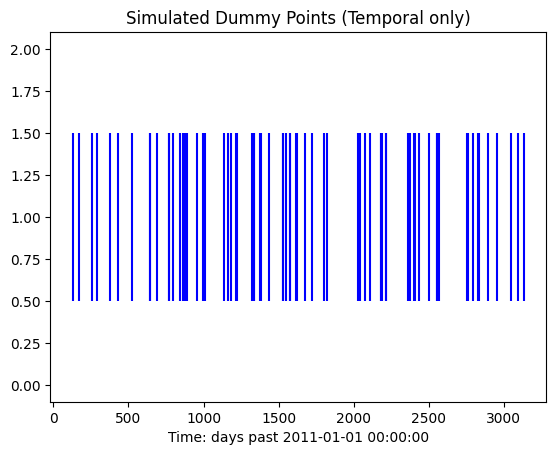

In [ ]:
## generate dummy point process data, adapted from https://hpaulkeeler.com/poisson-point-process-simulation/ and https://nbviewer.org/github/MatthewDaws/PointProcesses/blob/master/Temporal%20points%20processes.ipynb
# Define simulation window parameters if considering spatial data
# xMin = min(data['Latitude'])
# xMax = max(data['Latitude'])
# yMin = min(data['Longitude'])
# yMax = max(data['Longitude']) 
# xDelta = xMax-xMin
# yDelta = yMax-yMin
# areaTotal =xDelta*yDelta

# define time window parameters
tMin = min(data['Date'])
tMax = max(data['Date'])
tMin = pd.to_datetime(tMin)
tMax = pd.to_datetime(tMax)
# get total number of days between tMin and tMax
tDelta = (tMax - tMin).days


## ignore house category (otherwise define different intensity functions for different house categories)
def dummy_intensity(t):
    mult_factor = 60 ## adjust mult_factor so that it is at least 4x temporal risk (need to tune this parameter!)
    ## house_density = ## ADD if needed
    return (mult_factor * (0.5 + 0.25 * (np.sin(2*np.pi*t/365 + 0.5 * np.pi) + 1)))


def get_dummy(window):
    t = 0
    points = []
    while t < window:
        m = dummy_intensity(t)
        s = np.random.exponential(scale = m)
        points.append(t + s)
        print("dummy point: "+ str(t + s))
        t = t + s
    return points

print(tDelta)
dummy_points = get_dummy(tDelta)
plt.eventplot(dummy_points, orientation='horizontal', colors='b')
plt.xlabel('Time: days past '+ str(tMin))
plt.title('Simulated Dummy Points (Temporal only)')

In [57]:
## add extra column to data to store days past tMin
data['Days'] = 0
data['Date'] = pd.to_datetime(data['Date'])
data['Days'] = (data['Date'] - tMin).dt.days

In [58]:
## split data into train and test, use 2019 as test data
train_data = data[data['Date'] < '2019-01-01']
test_data = data[data['Date'] >= '2019-01-01']

Estimate model parameters $\theta_k$ (again here ignoring house categories)

Note: I couldn't figure out an efficient way to implement the exact method for fitting model parameters as outlined by Lu et al. (They recommend some packages in R that I couldn't find in python). I wrote a rough version where I assume the function orders are given (can change this manually by modifying the coeffs vector). Even my rough version here takes extremely long to run, takes 30 seconds to compute one instance of the likelihood :(

In [ ]:
def get_visibility(t):
    return data.loc[data['Days'] == t, 'Visibility'].values[0]

def get_windchill(t):
    return data.loc[data['Days'] == t, 'WindChill'].values[0]

In [ ]:
def get_intensity(t, thetas):
    ts = np.pi * t/365
    vis = get_visibility(t)
    windchill = get_windchill(t)
    coeffs = [1, np.cos(2*ts), np.sin(2*ts), np.cos(4*ts), np.sin(4*ts), np.cos(6*ts), np.sin(6*ts), np.cos(8*ts), np.sin(8*ts), vis, windchill, windchill ** 2]
    # return log of intensity
    return np.dot(coeffs, thetas)

In [46]:
## optimize thetas using train_data

# neg log likelihood for intensity 
def intensity_likelihood(given_data, thetas):
    t = train_data[given_data['Days'] > 0]['Days']
    lambdas = [get_intensity(i, thetas) for i in t]
    return (- np.sum(lambdas))

## find thetas that minimize neg log likelihood
from scipy.optimize import minimize
thetas = np.random.rand(12)
print("Compute neg log likelihood for random thetas:")
print(intensity_likelihood(train_data, thetas))

Compute neg log likelihood for random thetas:
-1463013579.8189843


In [ ]:
## this will take forever :(
def fit_intensity(given_data):
    ## add dummy points to train_data 
    def intensity_likelihood1(given_data, thetas):
    t = train_data[given_data['Days'] > 0]['Days']
    lambdas = [get_intensity(i, thetas) for i in t]
    return (- np.sum(lambdas))
    ## minimize neg_log_likelihood
    result = minimize(intensity_likelihood1, thetas, method='Nelder-Mead', options={'maxiter': 5000})
    fitted_thetas = result.x
    print("Optimized theta parameters: ", fitted_thetas)

Estimate likelihood ratio $w(X_i) = \frac{d\tilde{P}_X(X_i)}{dP_X (X_i)}$. 

In [48]:
from sklearn.linear_model import LogisticRegression

In [66]:
## take as inputs sets of with the date labels removed
def get_likelihood(set1, set2, x_new):
    ## label points in set1 as 1, points in set2 as 0
    set1['label'] = 1
    set2['label'] = 0
    all_data = pd.concat([set1, set2])
    ## adjust features as needed
    X = all_data[['WindSpeed', 'Temperature', 'WindChill', 'Sunshine', 'Visibility']]
    y = all_data['label']
    # Instantiate the model
    classifier = LogisticRegression(max_iter=500)

    # Train the model
    classifier.fit(X, y)

    prediction = classifier.predict_proba(x_new)
    print(prediction)
    return (prediction / (1 - prediction))


In [ ]:
## sample random day from test_data
sample_day = test_data.sample(1)
sample_day = sample_day[['WindSpeed', 'Temperature', 'WindChill', 'Sunshine', 'Visibility']]
print(sample_day)
sample_day_w = get_likelihood(train_data, test_data, sample_day)
print(sample_day_w)

Compute non-conformity score

In [47]:
## select a random day from test_data
test_point = test_data.sample(1)

## non-conformity score to find range of intensity values for test day 
def get_nc_score(test_day, y, training_set):
    ## fit theta from training set
    fitted_thetas = fit_intensity(training_set)
    ## get intensity of test_day
    intensity = get_intensity(test_day['Days'], thetas)
    return np.abs(y - intensity)